# CM4044 Mini Project 1

## Gathering and Loading Dataset

The FastF1 dataset can be accessed through the FastF1 Python library. It provides detailed information for each race event, including lap-by-lap performance data, car telemetry, weather conditions, session results, and driver profiles. From the telemetry data, users can access time-synchronized variables such as speed, throttle, brake, DRS activation, track position (X, Y), and more. From each session, we are able to get every lap data for all drivers.

### Objective

To build a highly accurate predictive model for qualifying time by leveraging features that reflect straight and cornering performance of F1 drivers in 2025.

## Table of Contents
1. [Load and Prepare Formula 1 Race Sessions](#load-sessions)
2. [Data Pre-Processing](#data-preprocessing)
3. [Regression Models](#regression)
4. [Classification Models](#classification)

In [ ]:
%pip install fastf1
import fastf1
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
import warnings
from pathlib import Path
import seaborn as sns
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
import datetime

%matplotlib inline
warnings.filterwarnings('ignore')
logging.getLogger('fastf1').setLevel(logging.WARNING)

fastf1.Cache.enable_cache(os.getcwd())

# Window size (range of the sliding window used in delta angle calculation)
N = 15

# Max and Min delta angle for a data point to be classified as being part of a corner
CORNER_THRESHOLD = 0.4

# Max speed for a data point to be classified as being part of a corner
SPEED_THRESHOLD = 200

### Load and Prepare Formula 1 Race Sessions <a name="load-sessions"></a>

In [ ]:
years = [2023, 2024, 2025]
sessions = {}
gp_events = ["Mexico City Grand Prix", "Brazilian Grand Prix", "Las Vegas Grand Prix", "Qatar Grand Prix", "Abu Dhabi Grand Prix"]

#Loading race session
def load_session(event, year):
    try:
        session = fastf1.get_session(year, event, 'R')
        session.load(telemetry=True, laps=True, weather=True)
        return year, event, session
    except Exception as e:
        print(f"Cannot load {event}.")
        return None

for year in years:
    schedule = fastf1.get_event_schedule(year)

    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = {executor.submit(load_session, e, year): e for e in gp_events}
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                year, event, session = result
                sessions[(year, event)] = session

## Data Pre-processing <a name="data-preprocessing"></a>

### Compute Cornering and Telemetry Metrics for Each Race

In [ ]:
race_stats = pd.DataFrame()
race_data = []

for event in gp_events:
    session = sessions[(2025, event)]
    try:
        telemetry = session.laps.pick_driver('VER').get_telemetry()
    except Exception as e:
        print(f"Timing data not available for {event}")
        continue
    telemetry = telemetry[['X', 'Y','Speed']]

    dx1 = telemetry['X'] - telemetry['X'].shift(N)
    dy1 = telemetry['Y'] - telemetry['Y'].shift(N)
    dx2 = telemetry['X'].shift(-N) - telemetry['X']
    dy2 = telemetry['Y'].shift(-N) - telemetry['Y']

    telemetry['Event'] = event

    telemetry['Delta_Angle'] = np.arctan2(dx1*dy2 - dy1*dx2, dx1*dx2 + dy1*dy2)
    telemetry['Delta_Angle'] = telemetry['Delta_Angle'].fillna(0)

    telemetry['IsCorner'] = ((telemetry['Delta_Angle'] > CORNER_THRESHOLD) | (telemetry['Delta_Angle'] < -CORNER_THRESHOLD) | (telemetry['Speed'] < SPEED_THRESHOLD))

    race_data.append(telemetry)

race_stats = pd.concat(race_data, ignore_index=True)
race_stats.to_csv("race_stats.csv", index=False)

### Visualize Telemetry Data and Cornering Events

In [ ]:
race_stats_csv = pd.read_csv("race_stats.csv")

for event in race_stats_csv["Event"].unique():
    event_data = race_stats_csv[race_stats_csv["Event"] == event]

    plt.figure(figsize=(6.4, 4.8))
    cmap = sns.color_palette('viridis', as_cmap = True)
    norm = plt.Normalize(vmin=race_stats_csv['Delta_Angle'].min(), vmax=race_stats_csv['Delta_Angle'].max())

    sc = sns.scatterplot(data=event_data,
                        x='X', y='Y',
                        hue='Delta_Angle',
                        palette='viridis',
                        hue_norm=norm,
                        legend=False,
                        edgecolor=None)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax = plt.gca())

    plt.savefig(f"Race Track Viz/{event}_deltaAngle.png")
    plt.close()

    plt.figure(figsize=(6.4, 4.8))
    sns.scatterplot(data=event_data,
                    x='X', y='Y',
                    hue='IsCorner',
                    palette={False: "blue", True: "red"},
                    edgecolor=None)

    plt.savefig(f"Race Track Viz/{event}_isCorner.png")
    plt.close()

### Extract Driver Lap Statistics and Telemetry Metrics

In [ ]:
def pick_median(laps):
    valid_laps = laps.dropna(subset=['LapTime']).reset_index(drop=True)
    if valid_laps.empty: return None
    times = valid_laps['LapTime'].dt.total_seconds()
    median_time = np.median(times)
    median_lap_index = (times - median_time).abs().argsort().iloc[0]
    return valid_laps.iloc[median_lap_index]

import requests
import pandas as pd
from bs4 import BeautifulSoup

url = "https://formulapedia.com/how-long-are-f1-races/"
track_info = {}

response = requests.get(url)

soup = BeautifulSoup(response.content, "html.parser")

tbl = soup.find("tbody")
row = tbl.find_all('tr')

for r in row:
    raceName = r.find('td', class_="column-1")
    circuitLength = r.find('td', class_="column-3")
    raceDistance = r.find('td', class_="column-4")
    numLaps = r.find('td', class_="column-5")

    track_info[raceName.text] = {"circuitLength": circuitLength.text.split("km")[0], "raceDistance": raceDistance.text.split("km")[0], "numLaps": numLaps.text}

track_info['Mexico City Grand Prix'] = track_info.pop("Mexican Grand Prix")
track_info["Qatar Grand Prix"] = {"circuitLength": 5.419, "raceDistance": 308.883, "numLaps": 57}

In [ ]:
df = pd.DataFrame()
rows = []

years_train_test = [2023, 2024]

for year in years_train_test:
    for event in gp_events:
        session = sessions[(year, event)]
        weather = session.weather_data
        
        for num in session.drivers:
            driver = session.get_driver(num)['Abbreviation']
            team = session.get_driver(num)['TeamName']
            
            driver_laps_all = session.laps.pick_driver(driver)
            if driver_laps_all.empty:
                continue
            
            #TODO filter out wet weather laps
            #INCLUDES laps done under green flag conditions, EXCLUDES pit in, pit out laps, as well as first lap
            valid_laps = driver_laps_all[(driver_laps_all['TrackStatus'] == '1') 
                                            & (driver_laps_all['PitInTime'].isna()) 
                                            & (driver_laps_all['PitOutTime'].isna()) 
                                            & (driver_laps_all['LapNumber'] > 1)].dropna(subset=['LapTime', 'Time']).reset_index(drop=True)
            if valid_laps.empty: continue
            
            valid_laps['Time_Minute'] = valid_laps['Time'].dt.round('min')
            
            for index, lap in valid_laps.iterrows():
                tel = lap.get_car_data()
                if tel is None:
                    continue

                weather_row = weather.iloc[(weather['Time'] - lap.Time).abs().argsort()[:1]]
                air_temp = weather_row['AirTemp'].values[0]
                track_temp = weather_row['TrackTemp'].values[0]
                
                corner_speeds = tel.query('Speed < 200')['Speed']
                straight_speeds = tel.query('Speed >= 200')['Speed']

                tyre_age = lap['TyreLife'] if 'TyreLife' in lap else lap['LapNumber'] - lap['StintStartLap']
                
                top_speed = 0
                top_speed_no_drs = 0
                if 'Speed' in tel:
                    lap_top_speed = tel['Speed'].max()
                    if lap_top_speed > top_speed:
                        top_speed = lap_top_speed
                else:
                    continue
                
                drs = tel['DRS'].values
                if 'Speed' in tel and drs.max() < 2: # looks for laps with no DRS enabled
                    lap_top_speed = tel['Speed'].max()
                    if lap_top_speed > top_speed_no_drs:
                        top_speed_no_drs = lap_top_speed
                else:
                    continue
                
                rows.append(
                    {
                        "Driver": driver,
                        "Team": team,
                        "Event": event,
                        "Year": year,
                        "LapTimeSeconds": lap['LapTime'].total_seconds(),
                        
                        "TyreCompound": lap['Compound'],
                        "TyreAge": tyre_age,
                        "AirTemp": air_temp,
                        "TrackTemp": track_temp,
                        
                        "TrackLength": track_info[event]["circuitLength"],
                        "RaceDistance": track_info[event]["raceDistance"],
                        "NumLaps": track_info[event]["numLaps"],
                        "LapNumber": lap['LapNumber'],

                        "TopSpeed": top_speed,
                        # "TopSpeedNoDelta": top_speed_no_drs,
                        "AvgCornerSpeed": corner_speeds.mean() if not corner_speeds.empty else None,
                        "AvgCornerEntrySpeed": corner_speeds.head(5).mean() if len(corner_speeds) >= 5 else None,
                        "AvgCornerExitSpeed": corner_speeds.tail(5).mean() if len(corner_speeds) >= 5 else None,
                        "AvgStraightSpeed": straight_speeds.mean()if not straight_speeds.empty else None,
                        "AvgStraightEntrySpeed": straight_speeds.head(5).mean() if len(straight_speeds) >= 5 else None,
                        "AvgStraightExitSpeed": straight_speeds.tail(5).mean() if len(straight_speeds) >= 5 else None,
                        "ThrottleMean": tel['Throttle'].mean(),
                        "ThrottleStdDev": tel['Throttle'].std(),
                        "BrakeMean": tel['Brake'].mean(),
                        "BrakeStdDev": tel['Brake'].std(),
                        "DRSMean": tel['DRS'].mean()
                    }
                )

df = pd.DataFrame(rows)

df.to_csv('f1.csv', index = False)

In [ ]:
%pip install patsy
%pip install statsmodels
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv("f1.csv")
df.dropna(inplace=True)

### Data information

In [ ]:
print(f"Shape: {df.shape}\n")
print(f"Size: {df.size}\n")
print(f"Driver distribution by {df.groupby('Team').size()}\n")
display(df.describe())

### Data Visualization

Visualization by PCA

### Assess Multicollinearity in Telemetry Features

In [ ]:
continuous_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
continuous_columns.remove("LapTimeSeconds")

# Check VIF (Multicolinearity)
formula = f'Q("LapTimeSeconds") ~ ' + ' + '.join([f'Q("{c}")' for c in continuous_columns])
Y, X = dmatrices(formula, data=df, return_type='dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

In [ ]:
# Check VIF again (Multicolinearity)
continuous_columns.remove("TrackLength")

formula = f'Q("LapTimeSeconds") ~ ' + ' + '.join([f'Q("{c}")' for c in continuous_columns])
Y, X = dmatrices(formula, data=df, return_type='dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

## Build and Evaluate Machine Learning Models (Regression models) <a name="regression"></a>

In [ ]:
x = df.drop(columns=['LapTimeSeconds'])
x = pd.get_dummies(x, columns=['Driver', 'Team', 'Event', 'TyreCompound'], drop_first=True)
y = df['LapTimeSeconds']

modelval_df = pd.DataFrame(columns=['Model', 'R-Squared', 'RMSE'])

### Linear Regression

In [ ]:
x_reduced = x.drop(columns=["TrackLength"])

x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=1)

model_lm = LinearRegression()
model_lm.fit(x_train, y_train)

y_pred_lm = model_lm.predict(x_test)

r2_lm = r2_score(y_test, y_pred_lm)
rmse_lm = np.sqrt(mean_squared_error(y_test, y_pred_lm))


modelval_df = pd.concat([modelval_df, pd.DataFrame([{'Model': 'Linear Regression',
                                                     'R-Squared': r2_lm,
                                                     'RMSE': rmse_lm}])
                                                     ], ignore_index=True)

print(f"R-Squared: {r2_lm}")
print(f"RMSE: {rmse_lm}")

modelval_df = modelval_df.drop_duplicates()

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV

x_reduced = x.drop(columns=["TrackLength"])

x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=1)

rf = RandomForestRegressor(random_state=1)

param_grid = {'n_estimators': list(range(31, 41)),
              'min_samples_leaf': list(range(1, 2))
              }

rand_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=0,
    random_state=1
)

rand_search_rf.fit(x_train, y_train)

print("Best params:", rand_search_rf.best_params_)

best_rf = rand_search_rf.best_estimator_

y_pred = best_rf.predict(x_test)

r2_rf = r2_score(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))

modelval_df = pd.concat([modelval_df, pd.DataFrame([{'Model': 'Random Forest Regression',
                                                     'R-Squared': r2_rf,
                                                     'RMSE': rmse_rf}])
                                                     ], ignore_index=True)

print(f"Test R-Squared: {r2_rf}")
print(f"Test RMSE: {rmse_rf}")

modelval_df = modelval_df.drop_duplicates()

importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False).head(10)
importances.sort_values().plot(kind='barh')
plt.show()

### XGBoost Regressor

In [ ]:
%pip install xgboost

import xgboost as xgb

x_reduced = x.drop(columns=["TrackLength"])

x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=1)

xg = xgb.XGBRegressor(random_state=1)

param_grid = {"n_estimators": list(range(650, 750)),
              "learning_rate": [0.03, 0.035, 0.04, 0.045, 0.05]
              }

rand_search_xgb = RandomizedSearchCV(
    estimator=xg,
    param_distributions=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=0,
    random_state=1
)

rand_search_xgb.fit(x_train, y_train)

print("Best params:", rand_search_xgb.best_params_)

best_xgb = rand_search_xgb.best_estimator_

y_pred = rand_search_xgb.predict(x_test)

r2_xg = r2_score(y_test, y_pred)
rmse_xg = np.sqrt(mean_squared_error(y_test, y_pred))

modelval_df = pd.concat([modelval_df, pd.DataFrame([{'Model': 'XGBoost Regression',
                                                     'R-Squared': r2_xg,
                                                     'RMSE': rmse_xg}])
                                                     ], ignore_index=True)

print(f"R-Squared: {r2_xg}")
print(f"RMSE: {rmse_xg}")

modelval_df = modelval_df.drop_duplicates()

importances = pd.Series(best_xgb.feature_importances_, index=x_train.columns).sort_values(ascending=False).head(10)
importances.sort_values().plot(kind='barh')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

display(modelval_df)

sns.barplot(y='Model', x='R-Squared', data=modelval_df, ax=ax[0])
ax[0].set_title('R-squared by Model')
ax[0].set_xlim(0, 1)
for p in ax[0].patches:
    ax[0].annotate(
        format(p.get_width(), '.3f'),     
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha='left', va='center',
        fontsize=10, color='white',
        xytext=(-40, 0),       
        textcoords='offset points'
    )

sns.barplot(y='Model', x='RMSE', data=modelval_df, ax=ax[1])
ax[1].set_title('RMSE by Model')
for p in ax[1].patches:
    ax[1].annotate(
        format(p.get_width(), '.3f'),
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha='left', va='center',
        fontsize=10, color='white',
        xytext=(-40, 0),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

Quantifying the Irreducible Error

Theoretical minimum RMSE at R²=1: 0.3562501450175972
Theoretical RMSE at R²=0.999: 0.383722731090117


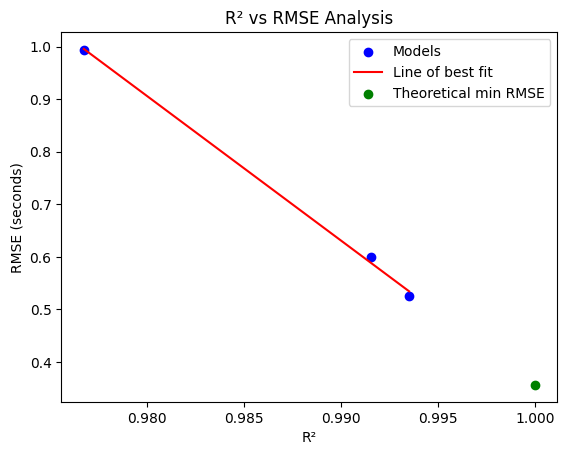

In [54]:
linreg = LinearRegression()
X = modelval_df["R-Squared"].values.reshape(-1, 1)
Y = modelval_df["RMSE"].values

linreg.fit(X, Y)

slope = linreg.coef_[0]
intercept = linreg.intercept_

rmse_r2_1 = linreg.predict(np.array([[1]]))[0]
rmse_r2_0999 = linreg.predict(np.array([[0.999]]))[0]

print("Theoretical minimum RMSE at R²=1:", rmse_r2_1)
print("Theoretical RMSE at R²=0.999:", rmse_r2_0999)

plt.scatter(modelval_df["R-Squared"], modelval_df["RMSE"], color='blue', label='Models')
plt.plot(X, linreg.predict(X), color='red', label='Line of best fit')
plt.scatter([1], [rmse_r2_1], color='green', label='Theoretical min RMSE')
plt.xlabel("R²")
plt.ylabel("RMSE (seconds)")
plt.title("R² vs RMSE Analysis")
plt.legend()
plt.show()

## Build and Evaluate Machine Learning Models (Classification models) <a name="classification"></a>

In [ ]:
years = [2025]
sessions = {}
gp_events = schedule[(schedule['EventName'].str.contains("Grand Prix")) & (schedule['EventDate'] <= datetime.datetime.now()) ]['EventName'].tolist()

#Loading race session for 2025 races
for year in years:
    schedule = fastf1.get_event_schedule(year)

    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = {executor.submit(load_session, e, year): e for e in gp_events}
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                year, event, session = result
                sessions[(year, event)] = session

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

url = "https://formulapedia.com/how-long-are-f1-races/"
track_info = {}

response = requests.get(url)

soup = BeautifulSoup(response.content, "html.parser")

tbl = soup.find("tbody")
row = tbl.find_all('tr')

for r in row:
    raceName = r.find('td', class_="column-1")
    circuitLength = r.find('td', class_="column-3")
    raceDistance = r.find('td', class_="column-4")
    numLaps = r.find('td', class_="column-5")

    track_info[raceName.text] = {"circuitLength": circuitLength.text.split("km")[0], "raceDistance": raceDistance.text.split("km")[0], "numLaps": numLaps.text}

track_info['Saudi Arabian Grand Prix'] = track_info.pop("Saudi Arabia Grand Prix")
track_info["Emilia Romagna Grand Prix"] = {"circuitLength": 4.909, "raceDistance": 309.05, "numLaps": 19}

In [ ]:
df_c = pd.DataFrame()
rows = []
gp_events = schedule[(schedule['EventName'].str.contains("Grand Prix")) & (schedule['EventDate'] <= datetime.datetime.now()) ]['EventName'].tolist()

for event in gp_events:
    session = fastf1.get_session(2025, event, 'R')
    session.load(telemetry=True, laps=True, weather=True)
    weather = session.weather_data
    
    for num in session.drivers:
            driver = session.get_driver(num)['Abbreviation']
            team = session.get_driver(num)['TeamName']
            
            driver_laps_all = session.laps.pick_driver(driver)
            if driver_laps_all.empty:
                continue
            
            #TODO filter out wet weather laps
            #INCLUDES laps done under green flag conditions, EXCLUDES pit in, pit out laps, as well as first lap
            valid_laps = driver_laps_all[(driver_laps_all['TrackStatus'] == '1') 
                                            & (driver_laps_all['PitInTime'].isna()) 
                                            & (driver_laps_all['PitOutTime'].isna()) 
                                            & (driver_laps_all['LapNumber'] > 1)].dropna(subset=['LapTime', 'Time']).reset_index(drop=True)
            if valid_laps.empty: continue
            
            valid_laps['Time_Minute'] = valid_laps['Time'].dt.round('min')
            
            for index, lap in valid_laps.iterrows():
                tel = lap.get_car_data()
                if tel is None:
                    continue

                weather_row = weather.iloc[(weather['Time'] - lap.Time).abs().argsort()[:1]]
                air_temp = weather_row['AirTemp'].values[0]
                track_temp = weather_row['TrackTemp'].values[0]
                
                corner_speeds = tel.query('Speed < 200')['Speed']
                straight_speeds = tel.query('Speed >= 200')['Speed']

                tyre_age = lap['TyreLife'] if 'TyreLife' in lap else lap['LapNumber'] - lap['StintStartLap']
                
                top_speed = 0
                top_speed_no_drs = 0
                if 'Speed' in tel:
                    lap_top_speed = tel['Speed'].max()
                    if lap_top_speed > top_speed:
                        top_speed = lap_top_speed
                else:
                    continue
                
                drs = tel['DRS'].values
                if 'Speed' in tel and drs.max() < 2: # looks for laps with no DRS enabled
                    lap_top_speed = tel['Speed'].max()
                    if lap_top_speed > top_speed_no_drs:
                        top_speed_no_drs = lap_top_speed
                else:
                    continue
                
                rows.append(
                    {
                        "Driver": driver,
                        "Team": team,
                        "Event": event,
                        "Year": year,
                        "LapTimeSeconds": lap['LapTime'].total_seconds(),
                        
                        "TyreCompound": lap['Compound'],
                        "TyreAge": tyre_age,
                        "AirTemp": air_temp,
                        "TrackTemp": track_temp,
                        
                        "TrackLength": track_info[event]["circuitLength"],
                        "RaceDistance": track_info[event]["raceDistance"],
                        "NumLaps": track_info[event]["numLaps"],
                        "LapNumber": lap['LapNumber'],

                        "TopSpeed": top_speed,
                        # "TopSpeedNoDelta": top_speed_no_drs,
                        "AvgCornerSpeed": corner_speeds.mean() if not corner_speeds.empty else None,
                        "AvgCornerEntrySpeed": corner_speeds.head(5).mean() if len(corner_speeds) >= 5 else None,
                        "AvgCornerExitSpeed": corner_speeds.tail(5).mean() if len(corner_speeds) >= 5 else None,
                        "AvgStraightSpeed": straight_speeds.mean()if not straight_speeds.empty else None,
                        "AvgStraightEntrySpeed": straight_speeds.head(5).mean() if len(straight_speeds) >= 5 else None,
                        "AvgStraightExitSpeed": straight_speeds.tail(5).mean() if len(straight_speeds) >= 5 else None,
                        "ThrottleMean": tel['Throttle'].mean(),
                        "ThrottleStdDev": tel['Throttle'].std(),
                        "BrakeMean": tel['Brake'].mean(),
                        "BrakeStdDev": tel['Brake'].std(),
                        "DRSMean": tel['DRS'].mean()
                    }
                )

df_c = pd.DataFrame(rows)

df_c.to_csv('f1_classification.csv', index = False)

Read "f1_classification.csv" into dataframe for classification models

In [ ]:
df_c = pd.read_csv("f1_classification.csv")
df_c.dropna(inplace=True)

In [ ]:
x = df_c.drop(columns=['LapTimeSeconds'])
x = pd.get_dummies(x, columns=['Driver', 'Team', 'Event', 'TyreCompound'], drop_first=True)
y = df_c['LapTimeSeconds']

In [ ]:
labels = []
median_straight = df_c['AvgStraightSpeed'].median()
median_corner = df_c['AvgCornerSpeed'].median()

std_straight = df_c['AvgStraightSpeed'].std()
std_corner = df_c['AvgCornerSpeed'].std()

threshold = 0.5

#TODO: EDIT GOOD AND BAD PARAMETERS FOR STRAIGHTS AND CORNERS
for _, row in df_c.iterrows():
        bool_straight = row['AvgStraightSpeed'] >= median_straight + threshold * std_straight
        bool_corner = row['AvgCornerSpeed'] >= median_corner + threshold * std_corner

        if bool_straight and not bool_corner:
            labels.append("Good in straights")
        elif not bool_straight and bool_corner:
            labels.append("Good in corners")
        elif bool_straight and bool_corner:
            labels.append("Good at both")
        else:
            labels.append("Bad at both")

### PCA

In [ ]:
#PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# load dataset
# features = ['TopSpeed','QualifyingTime','AvgCornerSpeed','AvgCornerEntrySpeed','AvgCornerExitSpeed',
        #     'AvgStraightSpeed','AvgStraightEntrySpeed','AvgStraightExitSpeed']

x = df_c.drop(columns=["LapTimeSeconds"]) # Separating out the features
x = pd.get_dummies(x, columns=['Driver', 'Team', 'Event', 'TyreCompound'], drop_first=True)
x_scaled = StandardScaler().fit_transform(x) # Standardizing the features

def plot_pca(x, y, target,component_num=12, pc_x=1, pc_y=2):
        y = df_c[target] # Separating out the target
        pca = PCA(n_components=component_num)
        pc = pca.fit_transform(x)

        #2D table
        pc_cols = [f'PC{i+1}' for i in range(component_num)]
        pc_df = pd.DataFrame(data = pc , columns = pc_cols)
        pc_df[target] = y.values
        #print(pc_df.head()) #check

        print("Explained variance ratio (all PCs):",pca.explained_variance_ratio_)
        total_var = np.sum(pca.explained_variance_ratio_)
        print("Total variance (all PCs):", total_var)
        chosen_var = (pca.explained_variance_ratio_[pc_x-1] + 
                      pca.explained_variance_ratio_[pc_y-1])
        print(f"Variance explained by PC{pc_x} and PC{pc_y}: {chosen_var:.4f}")

        #Variance plot of all the PCs
        var_df = pd.DataFrame({
                'Variance':pca.explained_variance_ratio_,
                'PC':[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]})
        sns.barplot(x='PC',y="Variance", data=var_df)
        plt.show()
        plt.close()

        #PCA visualization
        pcx, pcy = f'PC{pc_x}', f'PC{pc_y}'
        sns.lmplot(x=pcx, y=pcy,
                data=pc_df, 
                fit_reg=False, 
                hue=target, # color by cluster
                legend=True,
                scatter_kws={"s": 80})
        plt.show() # specify the point size
        plt.close()

plot_pca(x_scaled, y, target='Driver',component_num=12, pc_x=1, pc_y=2)
plot_pca(x_scaled, y, target='Event',component_num=12, pc_x=1, pc_y=2)
plot_pca(x_scaled, y, target='Team',component_num=12, pc_x=1, pc_y=2) #change pc_x and pc_y value to change PC view

We can observe race-dominant patterns. Important to perform classification by race

In [ ]:
dfc_filtered = df_c.loc[df_c['Event'] == 'Australian Grand Prix']

labels = []
median_straight = dfc_filtered['AvgStraightSpeed'].median()
median_corner = dfc_filtered['AvgCornerSpeed'].median()

std_straight = dfc_filtered['AvgStraightSpeed'].std()
std_corner = dfc_filtered['AvgCornerSpeed'].std()

threshold = 0.5

#TODO: EDIT GOOD AND BAD PARAMETERS FOR STRAIGHTS AND CORNERS
for _, row in dfc_filtered.iterrows():
        bool_straight = row['AvgStraightSpeed'] >= median_straight + threshold * std_straight
        bool_corner = row['AvgCornerSpeed'] >= median_corner + threshold * std_corner

        if bool_straight and not bool_corner:
            labels.append("Good in straights")
        elif not bool_straight and bool_corner:
            labels.append("Good in corners")
        elif bool_straight and bool_corner:
            labels.append("Good at both")
        else:
            labels.append("Bad at both")

### k-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

df_knn = dfc_filtered.drop(columns=["ThrottleMean", "TopSpeed", "AvgStraightExitSpeed", "BrakeStdDev"])

# x-axis for KNN
x = df_knn.drop(columns=['LapTimeSeconds', 'Driver', 'Team', 'Event', 'TyreCompound'])
selector = VarianceThreshold(threshold=0.01)
x_reduced = selector.fit_transform(x)

# y-axis for kNN
le = LabelEncoder()
y = le.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size = 0.2, random_state = 1, stratify = y)

# Finding optimal k value
max_k = len(x_train)
k_values = range(1, max_k + 1)
error_rate = []

p = 1 #Manhatten distance better

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k, p=p)
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)
    error_rate.append(np.mean(predictions != y_test))

best_k = error_rate.index(min(error_rate)) + 1

plt.plot(k_values, error_rate, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Error rate")
plt.title("Choosing Optimal k")
plt.show()

#Run proper kNN
knn = KNeighborsClassifier(n_neighbors = best_k, p=p)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print("F1:", f1)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(knn.get_params())



In [ ]:
print("y train: ", np.unique(y_train, return_counts=True))
print("y test: ", np.unique(y_test, return_counts=True))

### Support Vector Machine

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

df_svm = dfc_filtered.drop(columns=["ThrottleMean", "TopSpeed", "AvgStraightExitSpeed", "BrakeStdDev"])

# x-axis for SVM
x = df_svm.drop(columns=['LapTimeSeconds', 'Driver', 'Team', 'Event', 'TyreCompound'])
selector = VarianceThreshold(threshold=0.01)
x_reduced = selector.fit_transform(x)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_reduced)

#y-axis for SVM
y = LabelEncoder().fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state = 1, stratify = y)

# Hyperparameter tuning
# param_grid = {
#     'C': [0.1, 1, 10, 100],          
#     'kernel': ['linear', 'rbf', 'poly'],  
#     'gamma': ['scale', 'auto', 0.1, 0.01]  
# }

# grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
# grid.fit(x_train, y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best Cross-Validation Accuracy:", grid.best_score_)

#SVM
svm = SVC(kernel='linear', C=6, gamma='scale')
svm.fit(x_train, y_train)
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print("F1:", f1)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(svm.get_params())

### Naive Bayes Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

# remove highly correlated columns
nb_df1 = dfc_filtered.drop(columns=["ThrottleMean", "TopSpeed", "AvgStraightExitSpeed", "BrakeStdDev",
                                    'Year','TrackLength', 'RaceDistance'])

x = nb_df1.drop(columns=['LapTimeSeconds', 'Driver', 'Team', 'Event', 'TyreCompound'])
y_encoded = LabelEncoder().fit_transform(labels)

# ---quality correlation matrix---
numeric_df = nb_df1.select_dtypes(include=np.number)
k = len(numeric_df.columns) - 1 # number of variables for heatmap
cols = numeric_df.corr().nlargest(k, 'LapTimeSeconds')['LapTimeSeconds'].index #change QT 
cm = numeric_df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')
plt.title('Correlation Matrix')
plt.show()
plt.close()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

#hyperparameter tuning
# param_grid = {'var_smoothing': np.logspace(-12, -2, 20)}

# grid = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# grid.fit(x_train, y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best Cross-Validation Accuracy:", grid.best_score_)

nb = GaussianNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print("F1:", f1)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(nb.get_params())

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1, stratify=y
)

# param_grid = {
#     'C': np.logspace(-4, 4, 10),          
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga'],    
#     'max_iter': [500, 1000]
# }

# grid = GridSearchCV(
#     LogisticRegression(),
#     param_grid,
#     cv=5,
#     scoring='accuracy',
#     verbose=1,
#     n_jobs=-1
# )

# grid.fit(x_train, y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best Cross-Validation Accuracy:", grid.best_score_)

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

y_pred = nb.predict(x_test)  #evaluate the classifier by score 
acc = metrics.accuracy_score(y_test, y_pred)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print("F1:", f1)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(log_reg.get_params())

### K Means

In [ ]:
#k-means
from sklearn.cluster import KMeans

kmeans_df = dfc_filtered
x = kmeans_df['LapTimeSeconds']
hue1 = kmeans_df['Driver']

# ----data exploration---
plt.figure(figsize=(10,5))
plot1 = plt.subplot(1,2,1)
sns.scatterplot(x=x, y=kmeans_df['AvgCornerSpeed'], hue=hue1) #Corner speed plot
plot1.set_title('Avg Corner Speed')
# for i, driver in enumerate(df['Driver']): #label for driver for their respective dot
#     plot1.text(x.iloc[i]+0.05, df['AvgCornerSpeed'].iloc[i]+0.05, driver, fontsize=7)

plot2 = plt.subplot(1,2,2)
sns.scatterplot(x=x, y=kmeans_df['AvgStraightSpeed'], hue=hue1) #Straight speed plot
plot2.set_title('Avg Straight Speed')
# for i, driver in enumerate(df['Driver']): #label for driver for their respective dot
#     plot2.text(x.iloc[i]+0.05, df['AvgStraightSpeed'].iloc[i]+0.05, driver, fontsize=7)

# making common legend
handles, labels = plt.gca().get_legend_handles_labels()
plot1.get_legend().remove()
plot2.get_legend().remove()
plt.legend(handles, labels, title='Driver', loc='center left', bbox_to_anchor=(1.02, 0.5),
           fontsize=7, title_fontsize=8, markerscale=0.6, frameon=False)

plt.tight_layout()
plt.close()

# ---apply k-means clustering (CORNER SPEED)---
def kmeans_ml(feature1, feature2, cluster, n_clusters,):
    features = [feature1, feature2]
    X = kmeans_df[features]

    kmeans = KMeans(n_clusters=n_clusters, random_state=0) #change n clusters here
    kmeans.fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # --accessing corner clusters---
    kmeans_df[cluster] = kmeans.labels_
    cluster_summary = kmeans_df[[cluster, 'Driver','Team']].copy()
    cluster_summary1 = cluster_summary.sort_values(by=cluster)
    print(cluster_summary1)
    # print("Corner speed clustering\n")
    # for cluster_id in sorted(df['Cluster_Corner'].unique()):
    #     cluster_drivers = df.loc[df['Cluster_Corner'] == cluster_id, 'Driver'].unique()
    #     print(f"Cluster {cluster_id+1}: {', '.join(cluster_drivers)}")

    # Compute RMSE manually
    squared_errors = np.sum((X - centroids[labels])**2, axis=1)
    cluster_rmse = np.sqrt(np.mean(squared_errors))
    print("\nRMSE:", cluster_rmse, '\n')

    fig, ax = plt.subplots(1,1,figsize=(5,4))

    # Plot also the training points
    ax.scatter(kmeans_df[feature1], kmeans_df[feature2], 
            c= kmeans.labels_.astype(float), s=50, alpha=0.5)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
    for i, (x_c, y_c) in enumerate(centroids):
        ax.text(x_c, y_c, f'{i}', color='black', fontsize=10, fontweight='bold', 
                ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)

    plt.tight_layout()

    sse = []
    list_k = list(range(1, 20))

    for k in list_k:
        km = KMeans(n_clusters=k, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)

    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse, '-o')
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum of squared distance (SSE)');

    optimal_k = list_k[np.argmin(sse)]

kmeans_ml(feature1='LapTimeSeconds', feature2='AvgCornerSpeed', cluster='Corner_cluster', n_clusters=5)
# k = 4, RMSE: 7.104449474623985 
# k = 5, RMSE: 5.658441782468892 
# k = 6, RMSE: 5.205141483908022 
# Value of k = 5 is optimal for corner speed

kmeans_ml(feature1='LapTimeSeconds',feature2='AvgStraightSpeed', cluster='Straight_cluster', n_clusters=5)
# k = 4, RMSE: 7.325555946048033 
# k = 5, RMSE: 5.895425627708679 
# k = 6, RMSE: 5.033682884007996
# Value of k = 5 is optimal for straight speed

kmeans_ml(feature1='LapTimeSeconds', feature2='AvgStraightSpeed', cluster='Corner_cluster', n_clusters=6)
# k = 5, RMSE: 6.085387112431213 
# k = 6, RMSE: 4.769617581476588 
# k = 7, RMSE: 4.298916330457035 
# Value of k = 6 is optimal for straight speed

